In [1]:
from pathlib import Path

In [2]:
sampled_path = list(Path("sampled").glob("*jpg"))
sampled_path

[PosixPath('sampled/5.jpg'),
 PosixPath('sampled/3.jpg'),
 PosixPath('sampled/10.jpg'),
 PosixPath('sampled/8.jpg'),
 PosixPath('sampled/1.jpg'),
 PosixPath('sampled/4.jpg'),
 PosixPath('sampled/9.jpg'),
 PosixPath('sampled/7.jpg')]

In [3]:
sampled_path = sorted(sampled_path, key=lambda a: int(a.stem))
sampled_path

[PosixPath('sampled/1.jpg'),
 PosixPath('sampled/3.jpg'),
 PosixPath('sampled/4.jpg'),
 PosixPath('sampled/5.jpg'),
 PosixPath('sampled/7.jpg'),
 PosixPath('sampled/8.jpg'),
 PosixPath('sampled/9.jpg'),
 PosixPath('sampled/10.jpg')]

In [4]:
import cv2
import matplotlib.pyplot as plt


def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype("uint8")
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    rotated = cv2.rotate(a, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.figure(figsize=(30, 20))
    plt.axis("off")
    return plt.imshow(rotated, **kwargs)

sampled/7.jpg


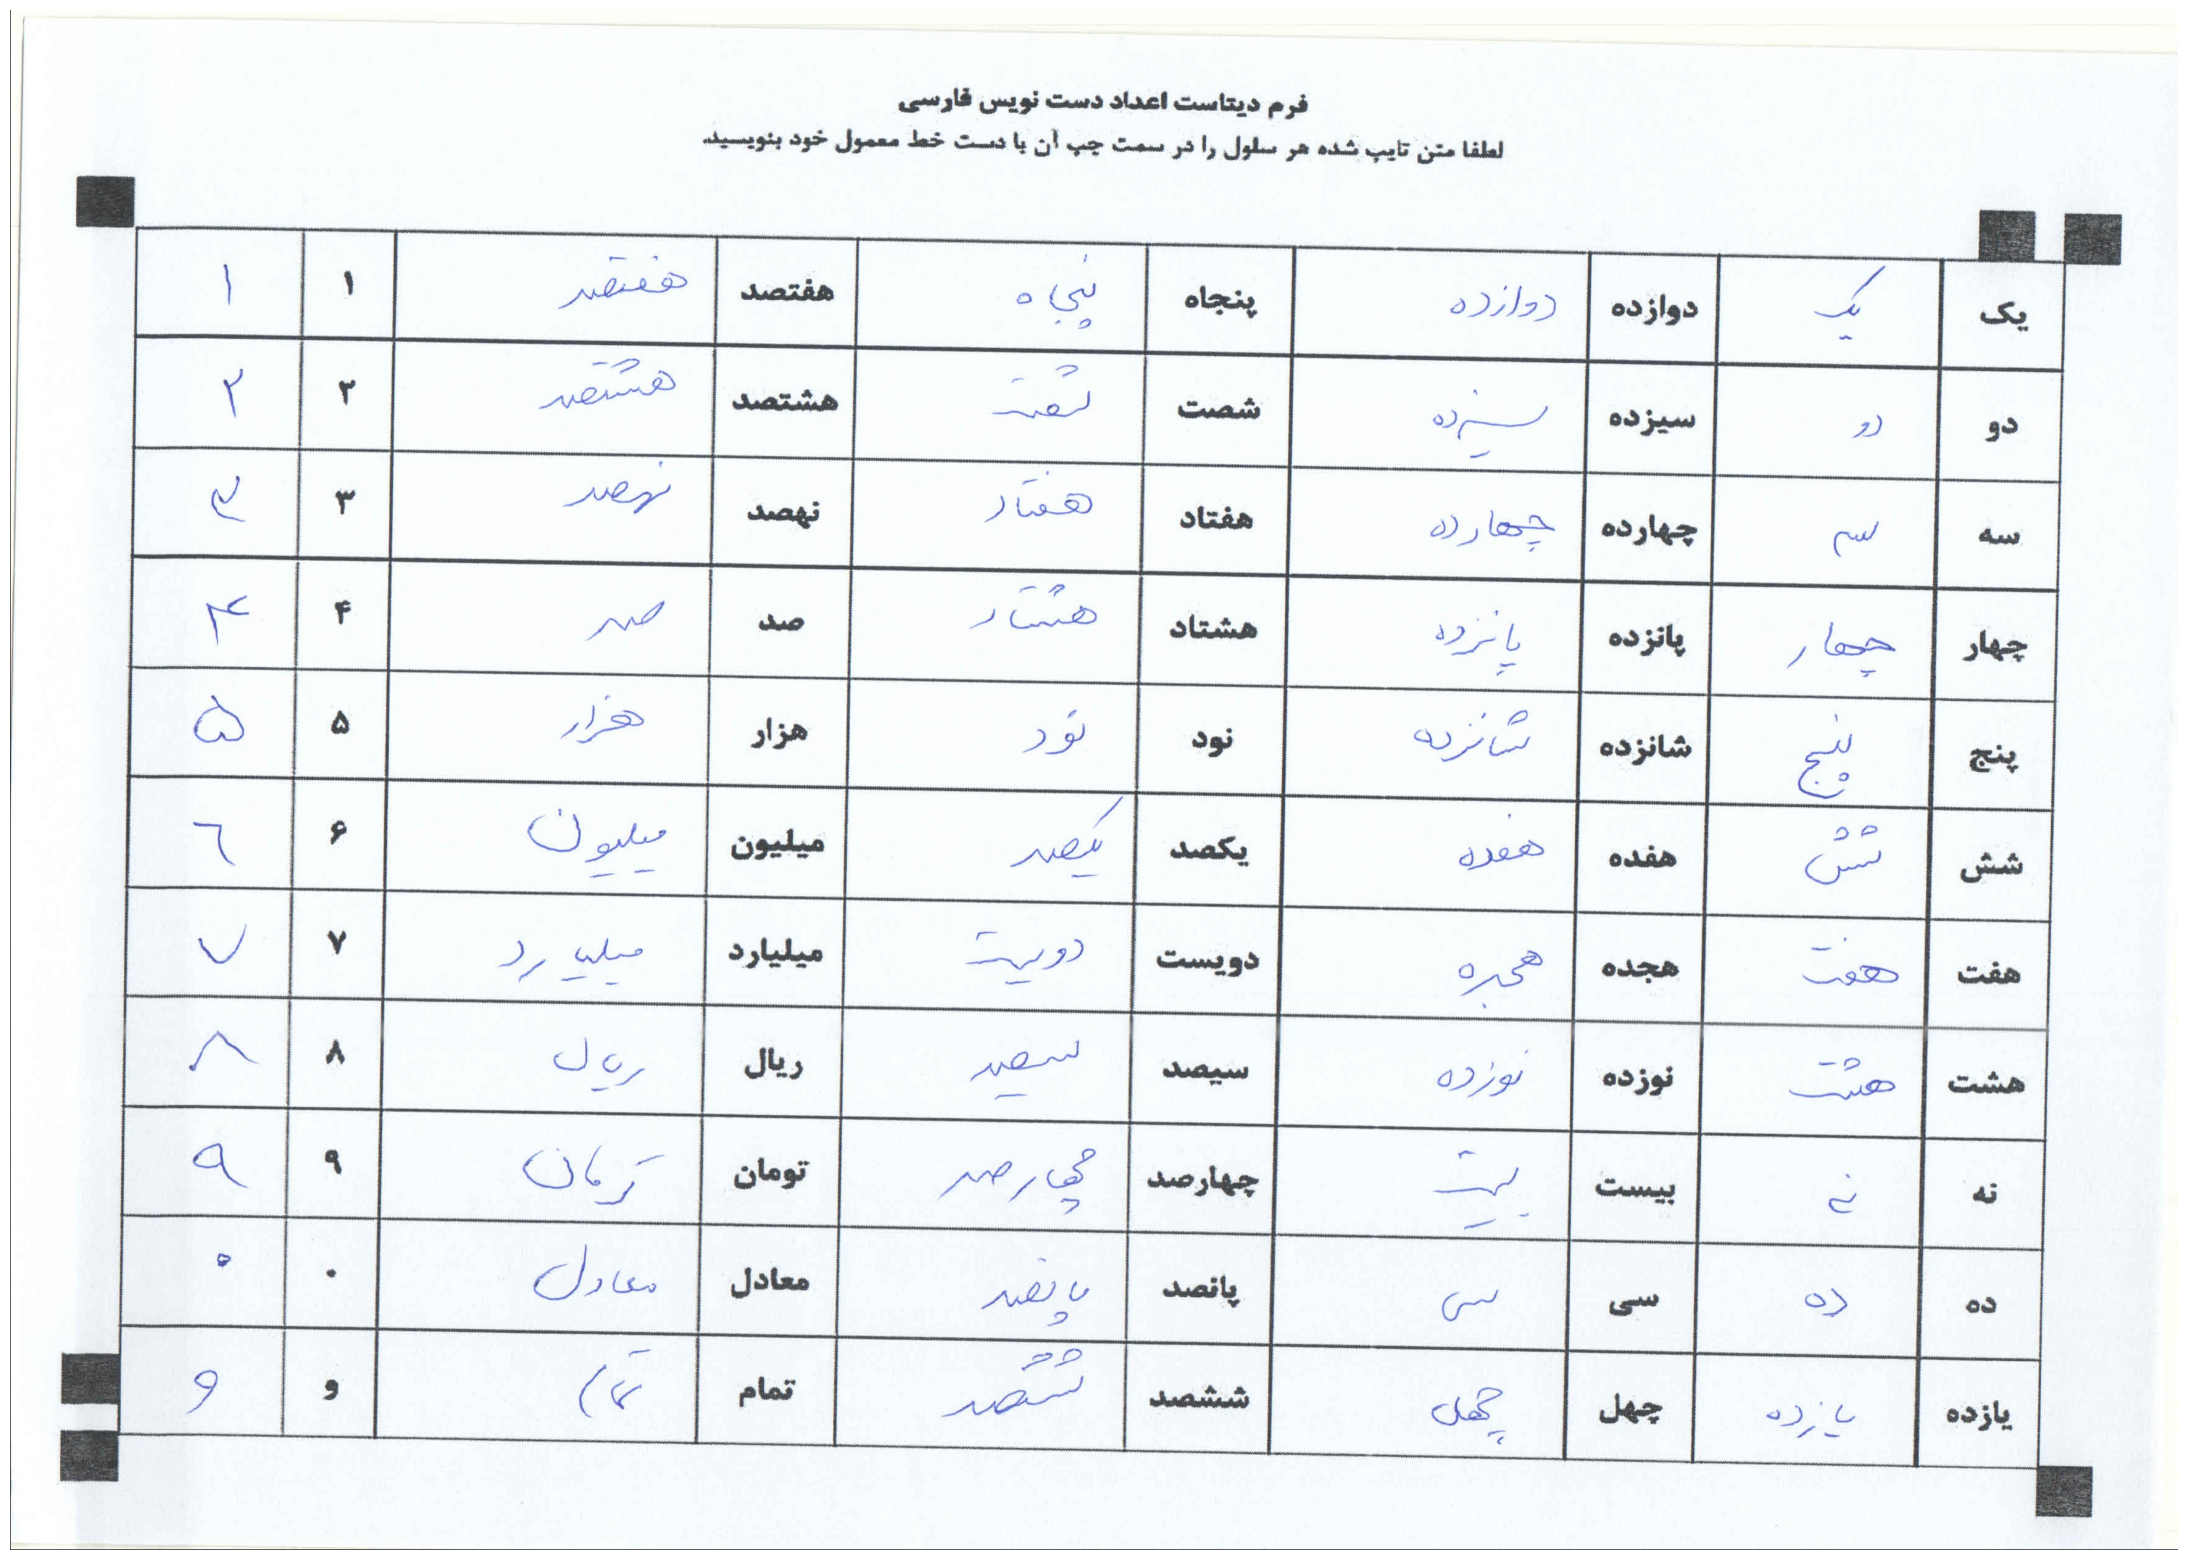

In [5]:
SAMPLE = str(sampled_path[-4])
print(SAMPLE)
img = cv2.imread(SAMPLE)
cv2_imshow(img)

In [6]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

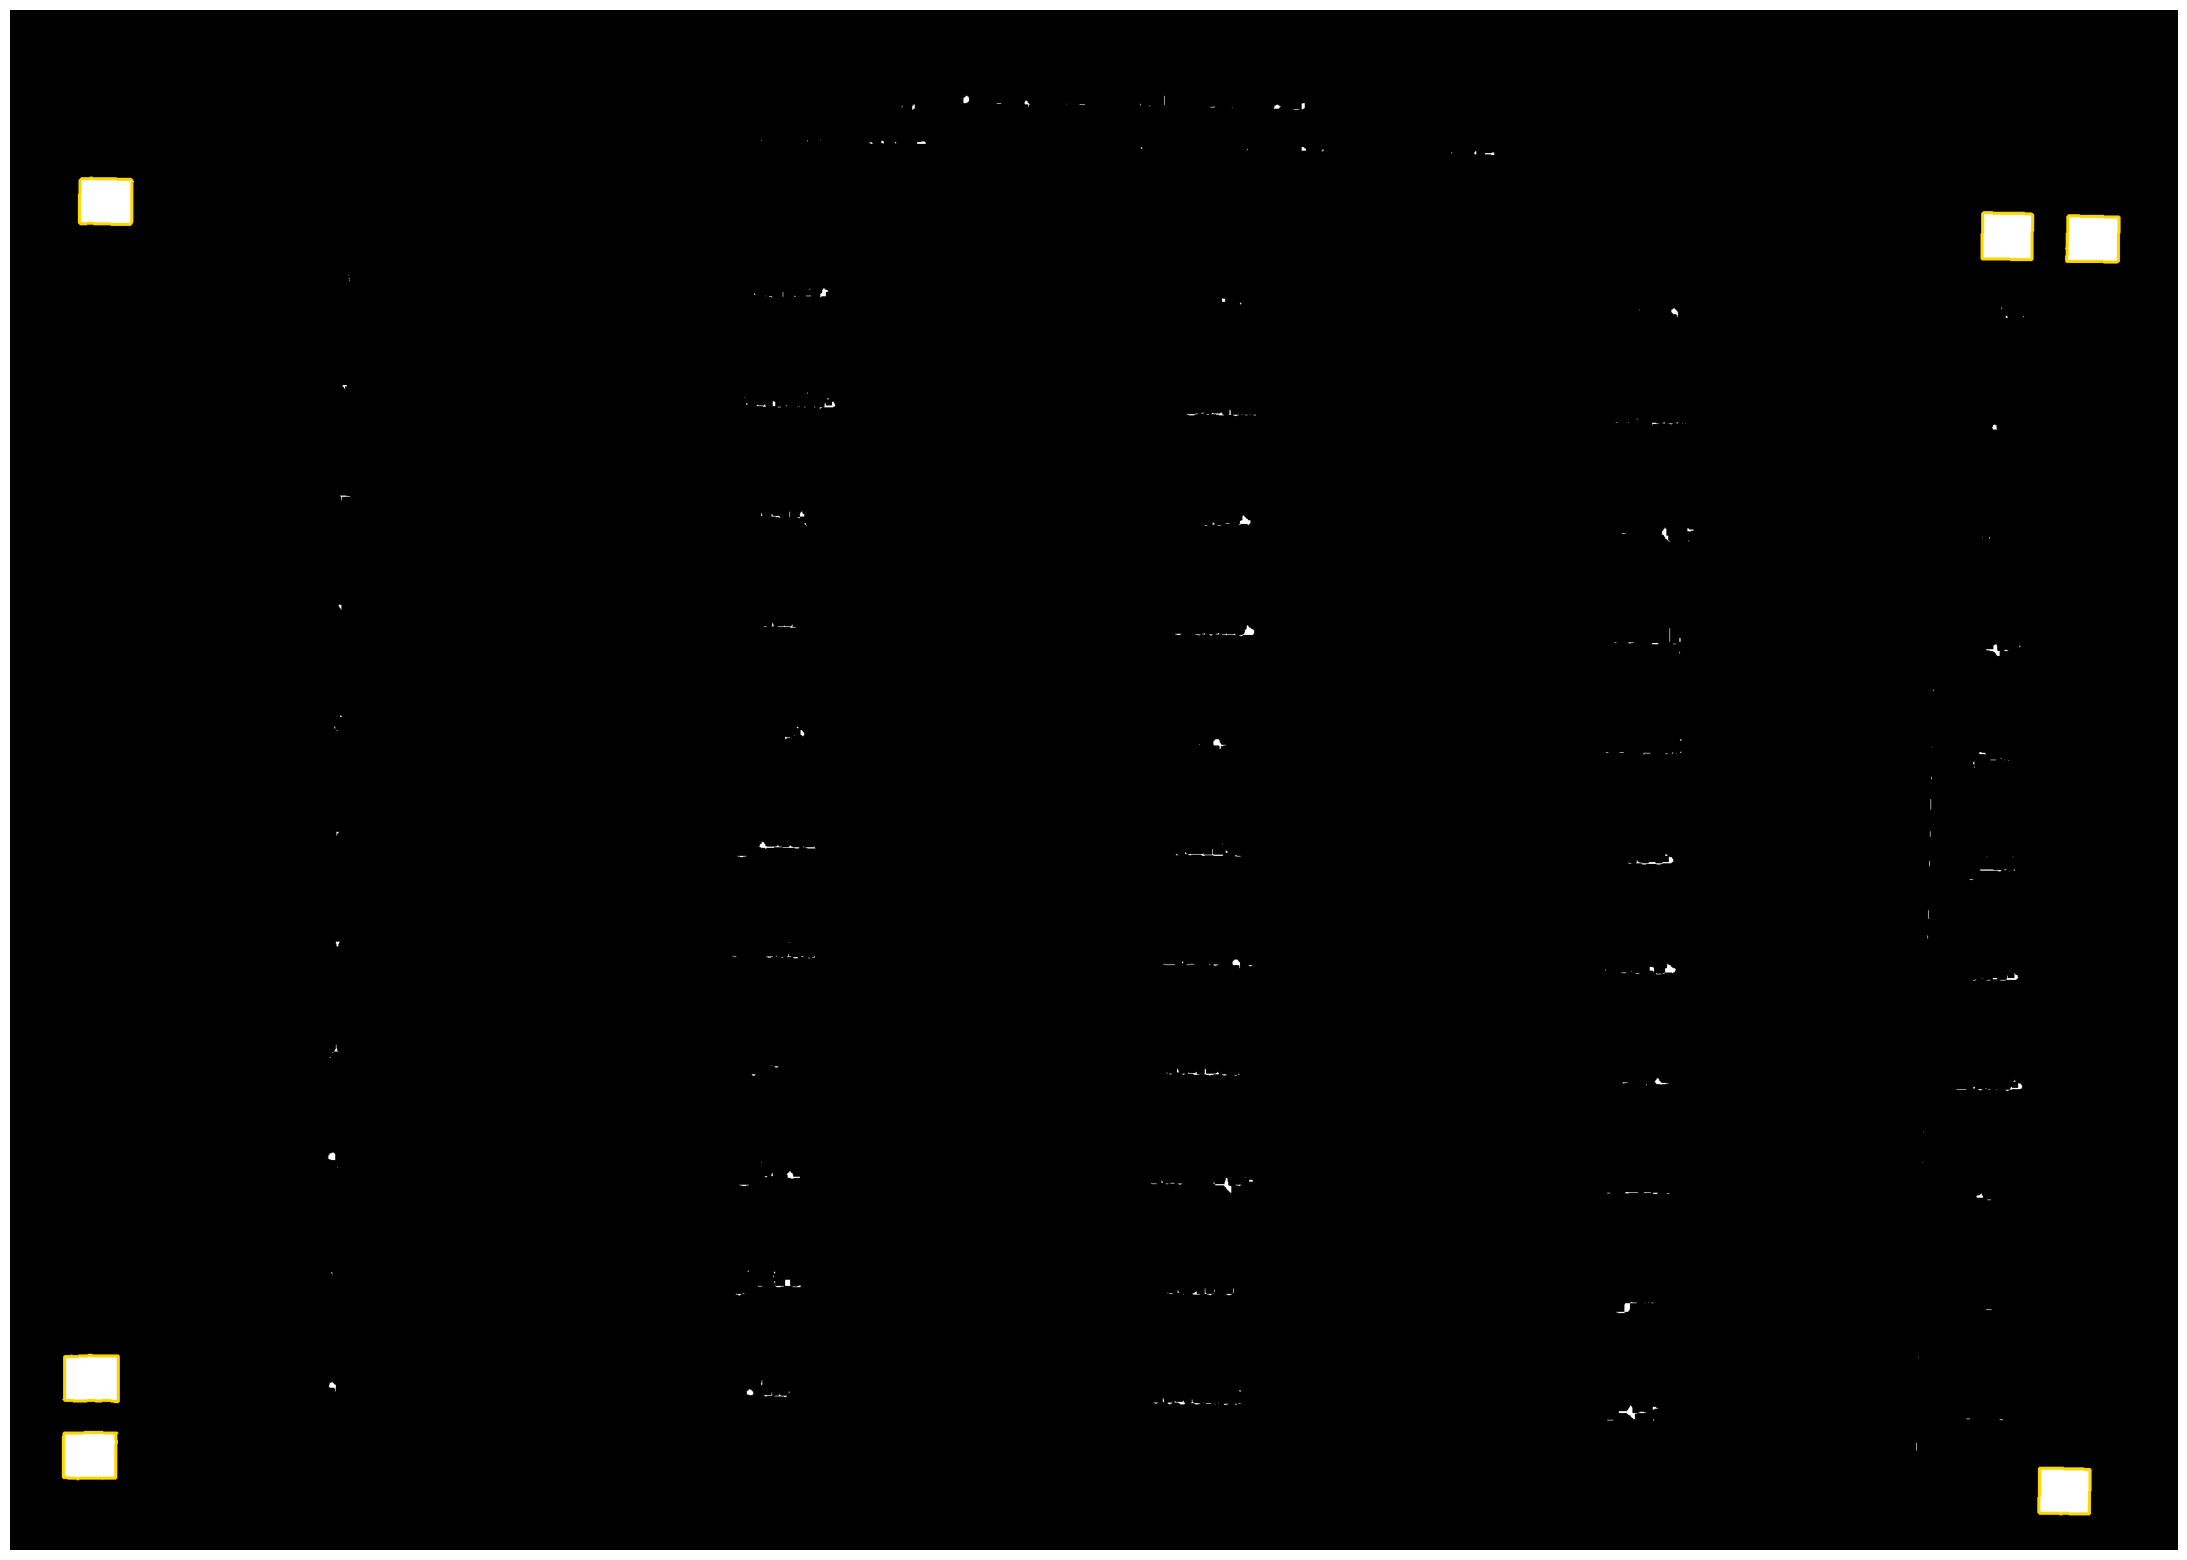

In [7]:
img_org = cv2.imread(SAMPLE)
img = cv2.imread(SAMPLE, 0)

thresh, img = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((10, 10), np.uint8)
img = cv2.erode(img, kernel)

contours, h = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
preview_img = np.expand_dims(img, axis=-1).repeat(3, axis=-1)
# cv2.drawContours(preview_img, contours, -1,(0,255,0),3)

paper_eyes = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # print(x, y, w, h)
    if w > 30 and h > 30:
        cv2.drawContours(preview_img, [cnt], 0, (0, 215, 255), 3)
        paper_eyes.append((x, y, w, h))

cv2_imshow(preview_img)

In [8]:
paper_eyes = np.array(paper_eyes)

In [9]:
def dist(a):
    return np.sqrt(a[:, 0] ** 2 + a[:, 1] ** 2)


dist(paper_eyes).argmin()

5

In [10]:
height, width = img.shape
topleft_mask = np.logical_and(
    paper_eyes[:, 0] < width // 2, paper_eyes[:, 1] < height // 2
)
topright_mask = np.logical_and(
    paper_eyes[:, 0] > width // 2, paper_eyes[:, 1] < height // 2
)
bottomright_mask = np.logical_and(
    paper_eyes[:, 0] > width // 2, paper_eyes[:, 1] > height // 2
)
bottomleft_mask = np.logical_and(
    paper_eyes[:, 0] < width // 2, paper_eyes[:, 1] > height // 2
)

In [11]:
print(topleft_mask)
print(topright_mask)
print(bottomright_mask)
print(bottomleft_mask)

[False False False False  True  True]
[False False False  True False False]
[ True False  True False False False]
[False  True False False False False]


In [12]:
print(paper_eyes[topleft_mask][paper_eyes[topleft_mask][:, 0].argmin()].ravel())
print(paper_eyes[topright_mask].ravel())
print(paper_eyes[bottomright_mask][paper_eyes[bottomright_mask][:, 1].argmax()].ravel())
print(paper_eyes[bottomleft_mask].ravel())

[115  86  76  88]
[2148  112   76   87]
[2087 3332   76   86]
[  58 3287   75   84]


In [ ]:
input_all = np.float32(
    [
        paper_eyes[topleft_mask][paper_eyes[topleft_mask][:, 0].argmin()].ravel(),
        paper_eyes[topright_mask].ravel(),
        paper_eyes[bottomright_mask][
            paper_eyes[bottomright_mask][:, 1].argmax()
        ].ravel(),
        paper_eyes[bottomleft_mask].ravel(),
    ]
)
input_ = np.float32(
    [
        paper_eyes[topleft_mask][paper_eyes[topleft_mask][:, 0].argmin()].ravel()[:2],
        paper_eyes[topright_mask].ravel()[:2],
        paper_eyes[bottomright_mask][
            paper_eyes[bottomright_mask][:, 1].argmax()
        ].ravel()[:2],
        paper_eyes[bottomleft_mask].ravel()[:2],
    ]
)
input_[0][0] += input_all[0][2]
input_[0][1] += input_all[0][3]
input_[1][1] += input_all[1][3]
input_[3][0] += input_all[3][2]
output_ = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

transform_matrix = cv2.getPerspectiveTransform(input_, output_)
preview_img = cv2.warpPerspective(
    img_org,
    transform_matrix,
    (width, height),
    cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=(0, 0, 0),
)
cv2_imshow(preview_img)

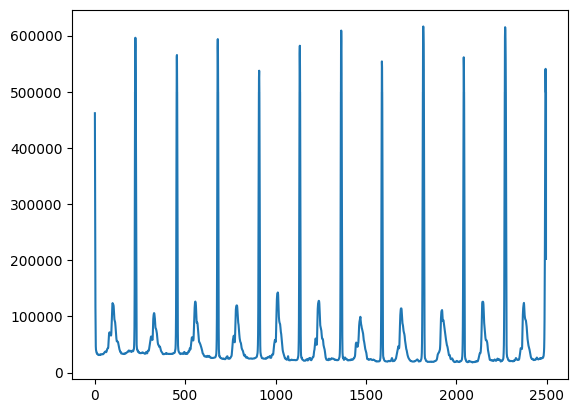

In [ ]:
plt.plot(cv2.bitwise_not(cv2.cvtColor(preview_img, cv2.COLOR_BGR2GRAY)).sum(axis=0))
peaks = find_peaks(
    cv2.bitwise_not(cv2.cvtColor(preview_img, cv2.COLOR_BGR2GRAY)).sum(axis=0),
    height=200000,
)[0]
for p in peaks:
    plt.vlines(p, 200000, 500000)

11


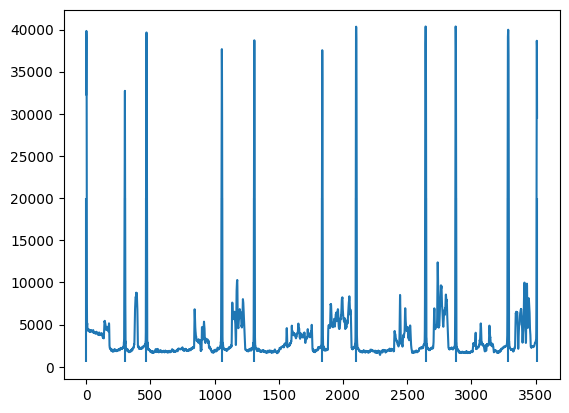

In [ ]:
from scipy.signal import find_peaks
vpeaks = find_peaks(cv2.bitwise_not(cv2.cvtColor(preview_img, cv2.COLOR_BGR2GRAY)).sum(axis=0), height=200000)[0]
print(len(vpeaks))

width, height, _ = preview_img.shape

vpeaks = [0] + sorted(vpeaks) + [width]
for idx in np.arange(len(vpeaks)):

  hpeaks = find_peaks(cv2.bitwise_not(cv2.cvtColor(preview_img[:, vpeaks[idx]:vpeaks[idx+1]], cv2.COLOR_BGR2GRAY)).sum(axis=1).ravel(), height=20000)[0]

  plt.plot(cv2.bitwise_not(cv2.cvtColor(preview_img[:, vpeaks[idx]:vpeaks[idx+1]], cv2.COLOR_BGR2GRAY)).sum(axis=1).ravel())

  for p in hpeaks:
    plt.vlines(p, 500, 20002)

  # cv2_imshow(preview_img[:, peaks[idx]:peaks[idx+1]])
  break

In [ ]:
blue_range = np.array([[128, 255, 255], [90, 50, 70]])
red_range = np.array([[0, 255, 255], [0, 50, 70]])
green_range = np.array([[60, 255, 255], [40, 50, 70]])

# white_range = np.ar
# # black_range = np.ar

In [ ]:
processed_path = Path("./processed/")
processed_path

PosixPath('processed')

In [ ]:
labels = [
    'word_1', 'word_12', 'word_50', 'word_700', 'digit_1',
    'word_2', 'word_13', 'word_60', 'word_800', 'digit_2',
    'word_3', 'word_14', 'word_70', 'word_900', 'digit_3',
    'word_4', 'word_15', 'word_80', 'word_100', 'digit_4',
    'word_5', 'word_16', 'word_90', 'word_1k', 'digit_5',
    'word_6', 'word_17', 'word_1sad', 'million', 'digit_6',
    'word_7', 'word_18', 'word_200', 'miliard', 'digit_7',
    'word_8', 'word_19', 'word_300', 'rial', 'digit_8',
    'word_9', 'word_20', 'word_400', 'toman', 'digit_9',
    'word_10', 'word_30', 'word_500', 'moadel', 'digit_0',
    'word_11', 'word_40', 'word_600', 'tamam', 'and',
]
print(len(labels))

55


In [ ]:
# check proportion  of blue range, red range and green range of image
def check_proportion(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blue_mask = cv2.inRange(img_hsv, blue_range[1], blue_range[0])
    red_mask = cv2.inRange(img_hsv, red_range[1], red_range[0])
    green_mask = cv2.inRange(img_hsv, green_range[1], green_range[0])
    blue_proportion = np.sum(blue_mask) / (blue_mask.shape[0] * blue_mask.shape[1])
    red_proportion = np.sum(red_mask) / (red_mask.shape[0] * red_mask.shape[1])
    green_proportion = np.sum(green_mask) / (green_mask.shape[0] * green_mask.shape[1])
    print(blue_proportion)
    print(red_proportion)
    print(green_proportion)
    return blue_proportion, red_proportion, green_proportion

check_proportion(preview_img)

4.727146696884101
0.0020647895727955506
0.0


(4.727146696884101, 0.0020647895727955506, 0.0)

120
60
55
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
     

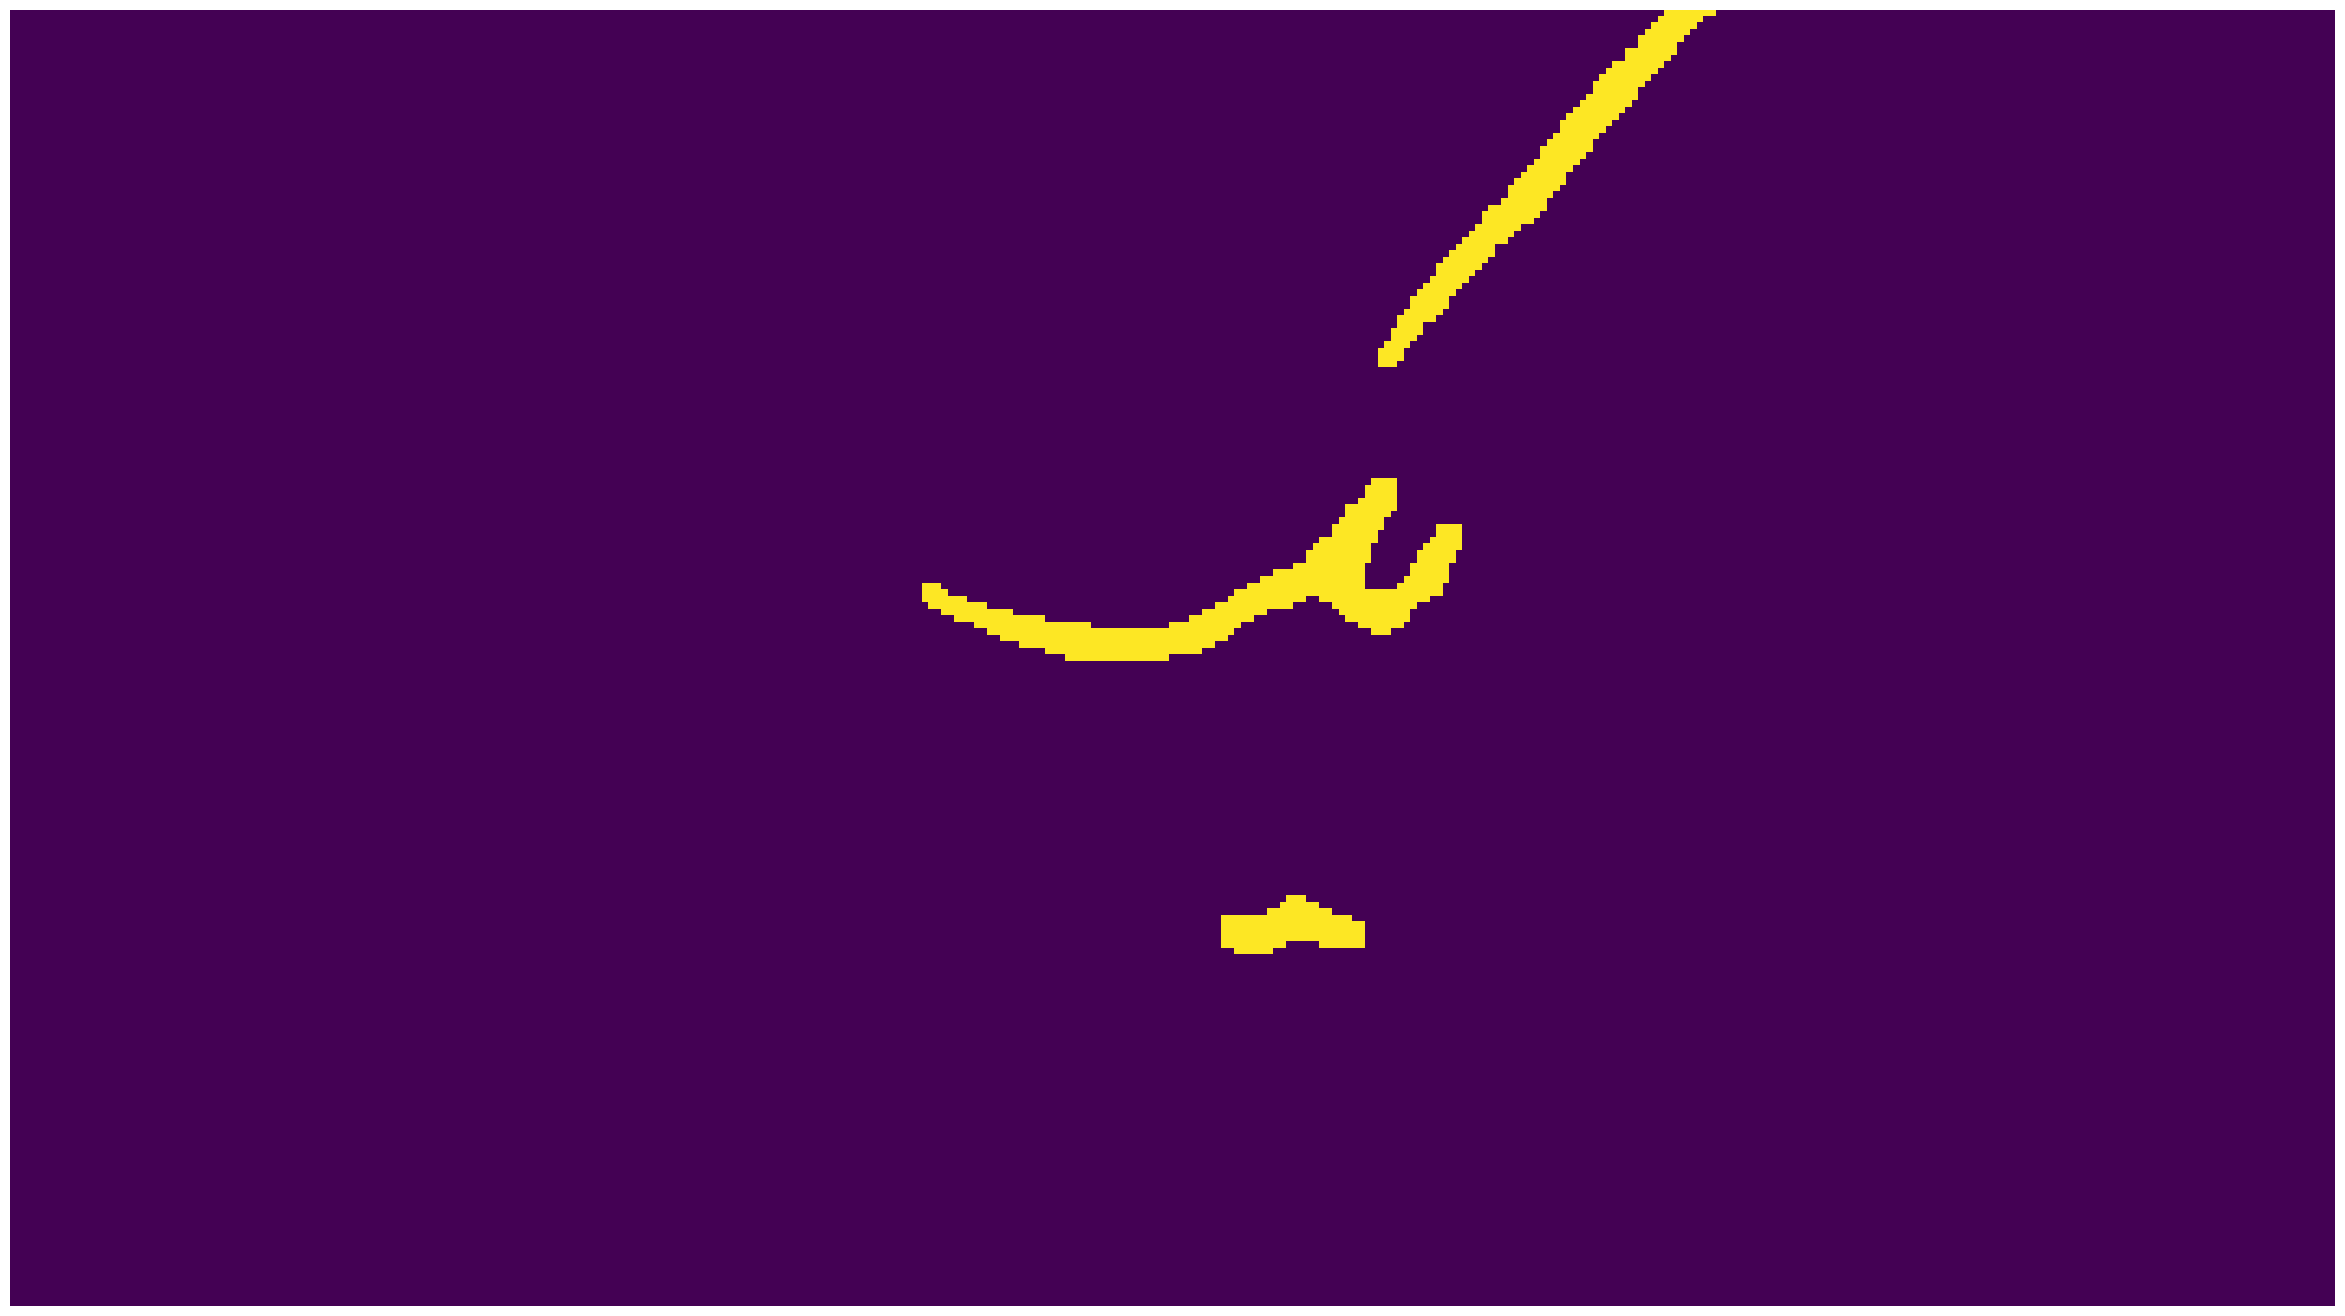

In [ ]:
width, height, _ = preview_img.shape
vpeaks = find_peaks(
    cv2.bitwise_not(cv2.cvtColor(preview_img, cv2.COLOR_BGR2GRAY)).sum(axis=0),
    height=200000,
)[0]
vpeaks = [0] + sorted(vpeaks) + [width]
hpeaks = find_peaks(
    cv2.bitwise_not(cv2.cvtColor(preview_img, cv2.COLOR_BGR2GRAY)).sum(axis=1),
    height=200000,
)[0]
hpeaks = [0] + sorted(hpeaks) + [height]

results = []
for vidx in np.arange(len(vpeaks)):
    for hidx in np.arange(len(hpeaks)):
        if hidx < len(hpeaks) - 1 and vidx < len(vpeaks) - 1 and hpeaks[hidx + 1] - hpeaks[hidx] > 50:
            part_img = preview_img[
                hpeaks[hidx] : hpeaks[hidx + 1], vpeaks[vidx] : vpeaks[vidx + 1]
            ]
            # cv2_imshow(part_img)

            hsv = cv2.cvtColor(part_img, cv2.COLOR_BGR2HSV)
            bluepenMask = cv2.inRange(hsv, blue_range[1], blue_range[0])
            morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
            # Perform closing:
            opIterations = 2
            bluepenMask = cv2.morphologyEx(
                bluepenMask,
                cv2.MORPH_OPEN,
                morphKernel,
                None,
                None,
                opIterations,
                cv2.BORDER_REFLECT101,
            )
            # bluepenMask = cv2.morphologyEx(bluepenMask, cv2.MORPH_CLOSE, morphKernel, None, None, opIterations, cv2.BORDER_REFLECT101)

            part_img = cv2.bitwise_and(part_img, part_img, mask=bluepenMask)
            # part_img = cv2.cvtColor(part_img, cv2.COLOR_BGR2GRAY)
            # th, threshed = cv2.threshold(part_img, 10, 255, cv2.THRESH_BINARY)
            # cv2_imshow(threshed)
            # results.append(threshed)
            results.append(part_img)

print(len(results))
results = results[0:-1:2]
print(len(results))

# crop to remove boarders
results = [result[40:-10, 5:-20] for result in results]
# reverse order
results = results[::-1]
# remove empty images
results = [result for result in results if np.sum(result) > 0]

print(len(results))
print(results)
cv2_imshow(results[0])

# write img to processed file using labels 
for idx, result in enumerate(results):
    print(idx)
    cv2.imwrite(
        str(processed_path) + f"/{labels[idx]}_{idx}.png", result
    )
